### Using SVD to fit a LJ potential

In [1]:
import numpy as np
from scipy.special import eval_chebyt
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
def LJ(r, epsilon=1, sigma=1):
    lj = 4 * epsilon * (np.power((sigma/r), 12) - np.power((sigma/r), 6))
    return lj

### smoothing function

In [3]:
def fs(r, r_out, fo=0.75):
    tersoff = np.zeros(r.shape)
    dt = r_out * (1 - fo)

    # a smart way to avoid direct comparison between r (an array) and r_out (a value)
    mask_out = r > r_out
    mask_in = r < dt
    mask_between = ~(mask_out | mask_in)

    tersoff[mask_in] = 1.0

    frac = (r[mask_between] - dt)/(r_out - dt)
    tersoff[mask_between] = 0.5 + 0.5 * np.sin(np.pi * frac + 0.5 * np.pi)
    return tersoff

### Visualize Chebyshev polynomial

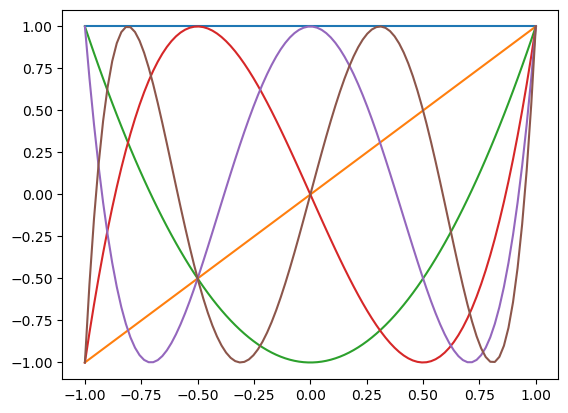

In [4]:
order = 6
s = np.linspace(-1, 1, 100)

plt.figure(dpi=100)
for i in range(order):
    T = eval_chebyt(i, s)
    plt.plot(s, T)

### Visualize morse transformation

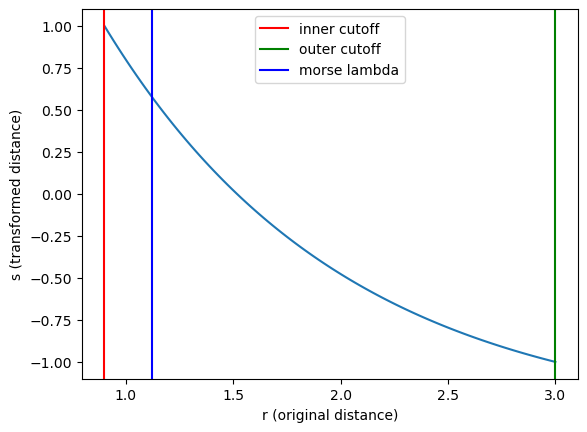

In [5]:
r_in = 0.9
r_out = 3
r = np.linspace(r_in, r_out, 100)
morse_lambda = 2 ** (1/6)

x = np.exp(-r/morse_lambda)
x_in = np.exp(-r_in/morse_lambda)
x_out =  np.exp(-r_out/morse_lambda)

x_avg = 0.5 * (x_in + x_out)
x_diff = 0.5 * np.abs(x_out - x_in)

s = (x - x_avg) / x_diff

plt.figure(dpi=100)
plt.plot(r, s)
plt.xlabel("r (original distance)")
plt.ylabel("s (transformed distance)")
plt.axvline(r_in, color="r", label="inner cutoff")
plt.axvline(r_out, color="g", label="outer cutoff")
plt.axvline(morse_lambda, color="b", label="morse lambda")
plt.legend()

### Plot Chebyshev polynomials for transformed distance

Text(0.5, 1.0, 'Chebyshev Polynomial Basis Functions')

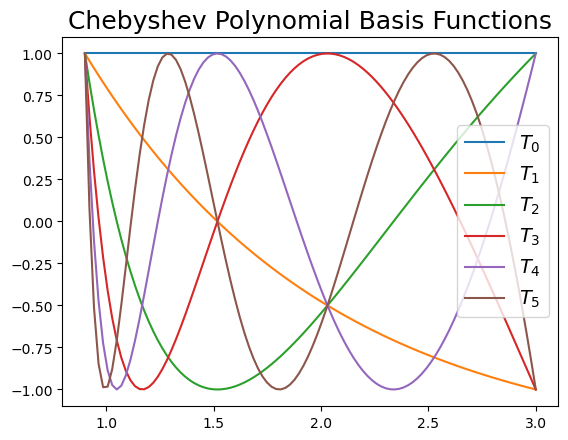

In [30]:
for i in range(order):
    T = eval_chebyt(i, s)
    plt.plot(r, T, label=fr"$T_{i}$")

plt.legend(fontsize=14)
plt.title("Chebyshev Polynomial Basis Functions", fontsize=18)

### Create matrix

In [7]:
A = []
tersoff = fs(r,r_out)
for i in range(order):
    column = eval_chebyt(i, s) * tersoff
    A.append(column)
A = np.stack(A).T
U_full, sigma_full, V_T_full = np.linalg.svd(A, full_matrices=True) 
U, sigma, V_T = np.linalg.svd(A, full_matrices=False) 
# only have 6 (order=6) sigular values, so don't need the full matrix to describe the system

In [8]:
V_T_full.shape

(6, 6)

### test orthonormal on U matrix

#### orthonormal requires A @ A_T = A @ A^-1 (inverse) = I (identity matrix)

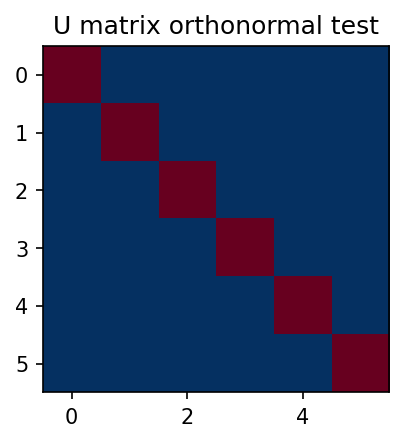

In [9]:
test = V_T_full @ V_T_full.T
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

ax1.set_title("U matrix orthonormal test")
im1 = ax1.imshow(test, cmap=cm.RdBu_r, vmin=0, vmax=1)

In [10]:
sigma.shape

(6,)

### plot A matrix in a color map
#### color correspond to the magnitude of values in the matrix

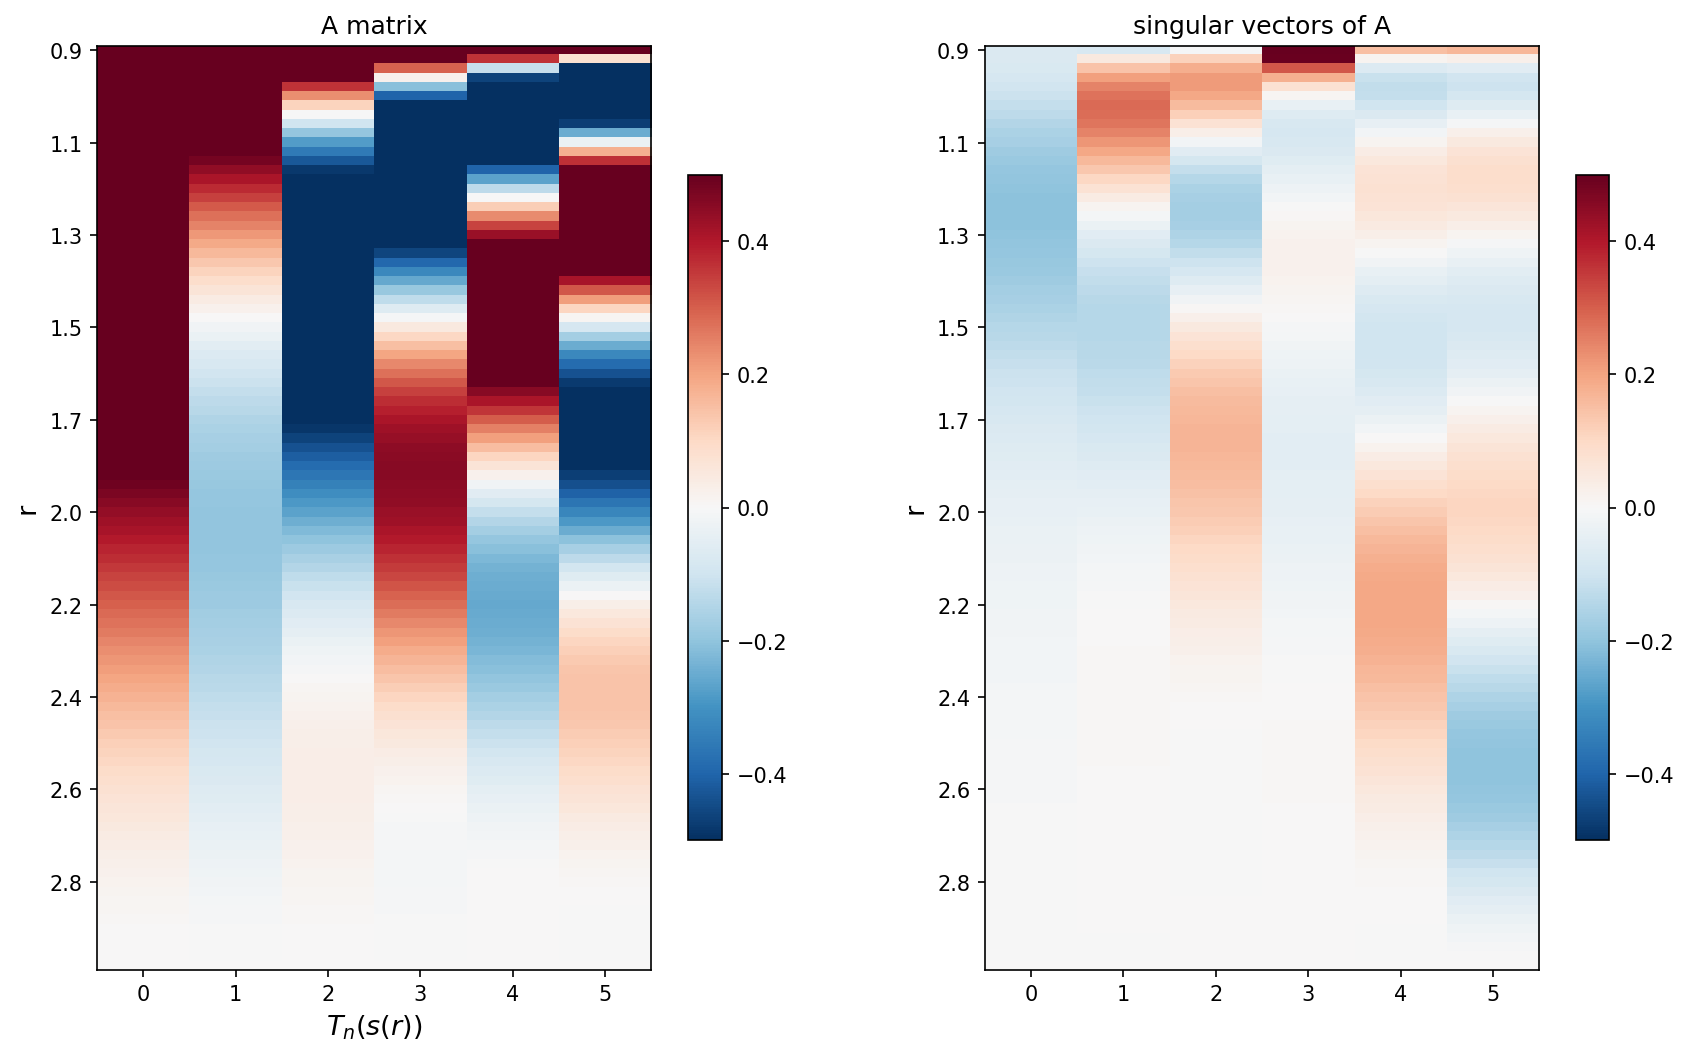

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8), dpi=150)

ax1.set_title("A matrix")
im1 = ax1.imshow(A, cmap=cm.RdBu_r, vmin=-0.5, vmax=0.5)
cbar = plt.colorbar(
    im1, ax=ax1, fraction=0.045, pad=0.05)
ax1.set_xlabel(r"$T_n(s(r))$", fontsize=13)
ax1.set_ylabel('r', fontsize=13)
xticks = list(range(0, order))
ax1.set_xticks(np.arange(0, order), xticks)
yticks = list(np.round(r[::10], 1))
ax1.set_yticks(np.linspace(0, r.shape[0], len(yticks), endpoint=False), yticks)
ax1.set_xticklabels(xticks)
ax1.set_yticklabels(yticks)
ax1.grid(False)
ax1.set_aspect(0.1)

ax2.set_title("singular vectors of A")
im2 = ax2.imshow(U, cmap=cm.RdBu_r, vmin=-0.5, vmax=0.5)
cbar = plt.colorbar(
    im2, ax=ax2, fraction=0.045, pad=0.05)
ax2.set_ylabel('r', fontsize=13)
xticks = list(range(0, order))
ax2.set_xticks(np.arange(0, order), xticks)
yticks = list(np.round(r[::10], 1))
ax2.set_yticks(np.linspace(0, r.shape[0], len(yticks), endpoint=False), yticks)
ax2.set_xticklabels(xticks)
ax2.set_yticklabels(yticks)
ax2.grid(False)
ax2.set_aspect(0.1)

### illustrate the weighting of the sigular values
#### in SVD, we can set the regularization threshold to drop small singular values. 

Text(0, 0.5, 'coefficient weighting')

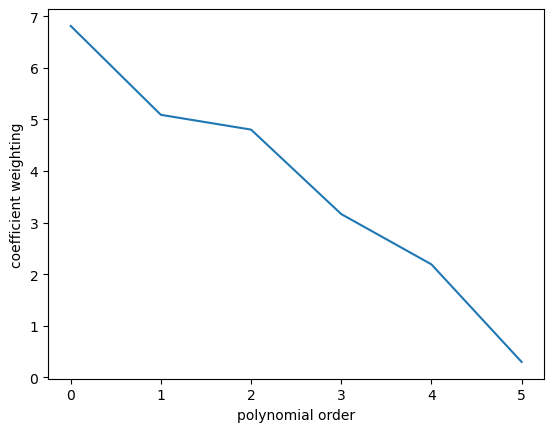

In [12]:
plt.plot(sigma)
plt.xlabel("polynomial order")
plt.ylabel("coefficient weighting")

### Reconstruct A matrix via SVD
#### SVD is a dimension reduction technique. When I use polynomial order of 6, the sigma matrix has 6 singular values. As a result, we can describe the same matrix with U, sigma, and V_T with reduced dimensionality. 

In [13]:
A_reconstruct = U @ np.diag(sigma) @ V_T 

In [14]:
# shows that A matrix and A_reconstrct is very similar
((A - A_reconstruct)**2).sum()

1.558339534066879e-28

In [15]:
c = V_T.T @ np.diag(1/sigma) @ U.T @ LJ(r).reshape(r.shape[0], -1) 

In [16]:
LJ(r).shape

(100,)

In [17]:
c

array([[-0.09743803],
       [ 2.42565386],
       [ 0.63987813],
       [ 2.18905233],
       [ 0.34752693],
       [ 0.82399395]])

### Fit and plot the model 

0.08165913717338602


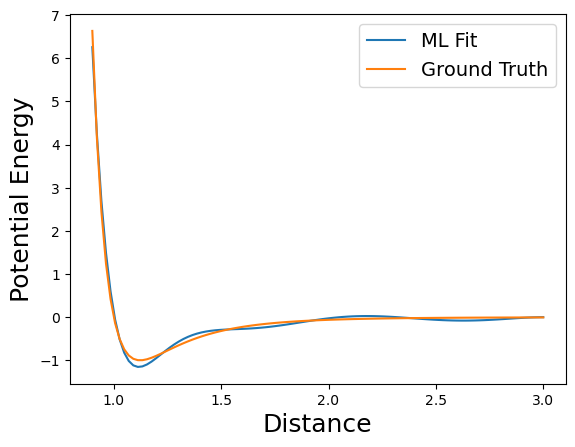

In [45]:
fit = 0
for i in range(order):
    fit += c[i] * eval_chebyt(i, s) 

fit *= tersoff # coeff considers fs, must * fs when plotting

plt.plot(r, fit, label="ML Fit")
plt.plot(r, LJ(r), label="Ground Truth")
plt.xlabel("Distance", fontsize=18)
plt.ylabel("Potential Energy", fontsize=18)
plt.legend(fontsize=14)

error = np.sqrt(np.mean((fit-LJ(r))**2))
print(error)

### Plot coefficients in a bar plot

Text(0, 0.5, 'coefficient')

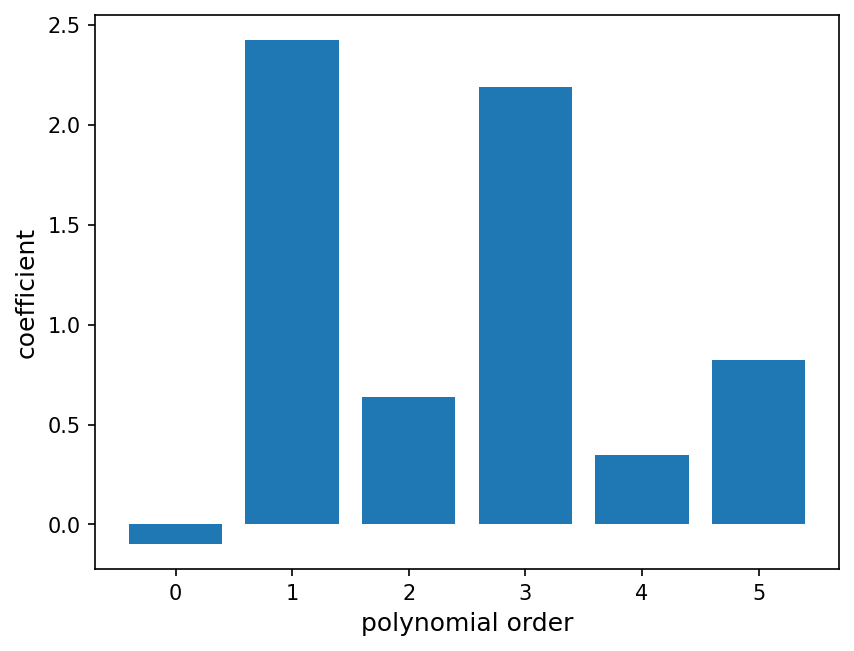

In [19]:
plt.figure(dpi=150)
plt.bar(np.arange(0, order, 1), c.flatten())
plt.xlabel("polynomial order", fontsize=12)
plt.ylabel("coefficient", fontsize=12)

### drop the smallest singular value

In [20]:
print(sigma)

[6.81211293 5.08894132 4.80279182 3.16609569 2.1913036  0.3008183 ]


In [21]:
new_sigma = sigma[:-1]
new_V_T = V_T[:-1, :-1]
new_U = U[:, :-1]

In [22]:
c_new = new_V_T.T @ np.diag(1/new_sigma) @ new_U.T @ LJ(r).reshape(r.shape[0], -1)

In [23]:
c_new

array([[0.59177456],
       [1.10737483],
       [1.73978464],
       [1.36627537],
       [0.83119392]])

### plot the difference 

0.08165913717338602


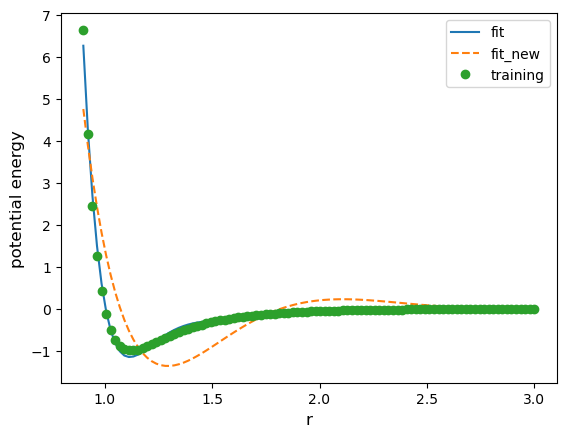

In [24]:
fit = 0
for i in range(order):
    fit += c[i] * eval_chebyt(i, s) 
fit_new = 0
for i in range(order-2):
    fit_new += c_new[i] * eval_chebyt(i, s) 

fit *= tersoff # coeff considers fs, must * fs when plotting
fit_new *= tersoff # coeff considers fs, must * fs when plotting

plt.plot(r, fit, label="fit")
plt.plot(r, fit_new, '--', label="fit_new")
plt.plot(r, LJ(r), 'o', label="training")
plt.xlabel("r", fontsize=12)
plt.ylabel("potential energy", fontsize=12)
plt.legend()

error = np.sqrt(np.mean((fit-LJ(r))**2))
print(error)

### plot coeffs

Text(0, 0.5, 'coefficient')

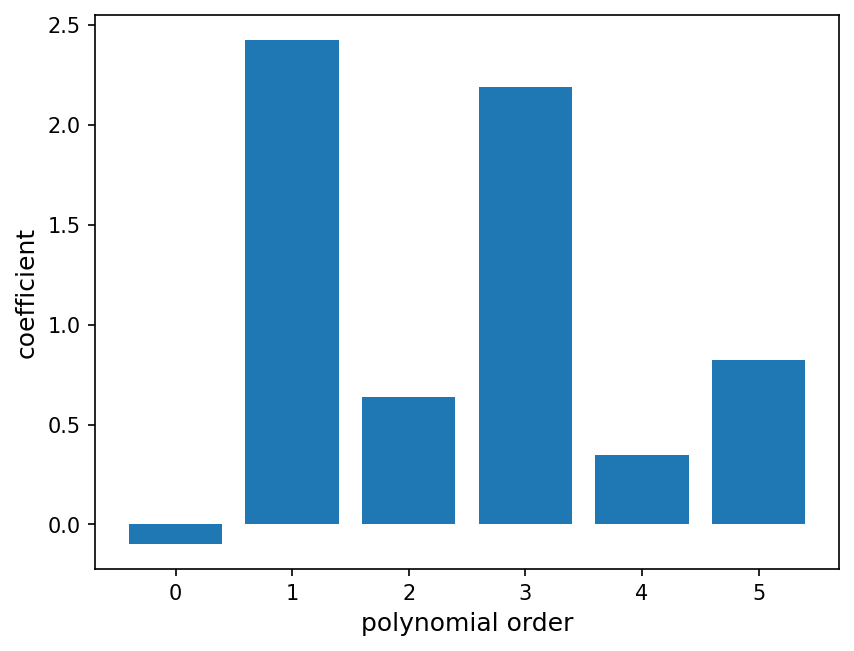

In [25]:
plt.figure(dpi=150)
plt.bar(np.arange(0, order, 1), c.flatten())
plt.xlabel("polynomial order", fontsize=12)
plt.ylabel("coefficient", fontsize=12)

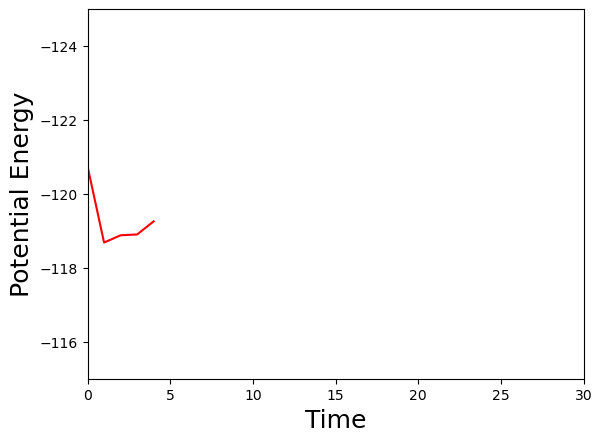

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Define constants
num_points = 50
constant_value = -120
fluctuation_range = 2

# Generate time values
time = np.arange(num_points)

# Generate fluctuating data around the constant value
data = constant_value + np.random.uniform(-fluctuation_range, fluctuation_range, num_points)

# Plot the data
#plt.plot(time, data, c='blue')
plt.plot(time[:5], data[:5],c='r')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Potential Energy', fontsize=18)
plt.ylim(-115,-125)
plt.xlim(0,30)
plt.show()
